In [1]:
from bw_recipe_2016 import (
    StratosphericOzoneDepletion,
    get_biosphere_database, 
    extract_recipe,
)

In [2]:
data = extract_recipe()[3]

In [3]:
biosphere = get_biosphere_database()

In [4]:
gw = StratosphericOzoneDepletion(data, biosphere)

In [5]:
gw.apply_strategies()

Applying strategy: fix_perspective_string
Applying strategy: generic_reformat
Applying strategy: split_synonyms
Applying strategy: more_synonyms
Applying strategy: fix_unit_string
Applying strategy: name_matcher
Applying strategy: add_air_category
Applying strategy: complete_method_name
Applying strategy: match_multiple
Applied 9 strategies in 0.03 seconds


In [6]:
gw.data[0]

{'name': ('ReCiPe 2016', 'v1.1 (20180117)', 'ODP20', 'Individualist'),
 'unit': 'kg CFC11-eq/kg ODS',
 'filename': 'ReCiPe2016_CFs_v1.1_20180117.xlsx',
 'description': '',
 'exchanges': [{'name': 'Halon-2402',
   'synonyms': ['H-2402'],
   'amount': 22.2,
   'categories': ('air',)},
  {'name': 'HCFC-225ca',
   'synonyms': [''],
   'amount': 0.05,
   'categories': ('air',)},
  {'name': 'HCFC-225cb',
   'synonyms': [''],
   'amount': 0.073,
   'categories': ('air',)},
  {'name': 'Halon-1202',
   'synonyms': [''],
   'amount': 4.247,
   'categories': ('air',)},
  {'name': 'methane, trichlorofluoro-, cfc-11',
   'synonyms': [''],
   'amount': 1.0,
   'categories': ('air',),
   'input': ('biosphere3', '51e99a55-bcdb-4d18-9484-6de4b142e09d')},
  {'name': 'methane, trichlorofluoro-, cfc-11',
   'synonyms': [''],
   'amount': 1.0,
   'categories': ('air',),
   'input': ('biosphere3', '33a69662-583b-45b8-8cb9-94f59fca9133')},
  {'name': 'methane, trichlorofluoro-, cfc-11',
   'synonyms': [''],


In [7]:
gw.write_excel("ozone-depletion")

Wrote matching file to:
/Users/cmutel/Library/Application Support/Brightway3/default.c21f969b/output/lcia-matching-ozone-depletion.xlsx


In [8]:
gw.statistics()

3 methods
282 cfs
12 unlinked cfs


(3, 282, 12)

In [9]:
c = gw.compare_to_previous()

In [10]:
[(key, len(c[key])) for key in c]

[('found', 18), ('missing', 4), ('reference', 18)]

Present in previous ReCiPe, missing here

In [11]:
c['reference'].difference(c['found'])

{'ethane, 1,1,2-trichloro-'}

In [12]:
c['found']

{'dinitrogen monoxide',
 'ethane, 1,1,1-trichloro-, hcfc-140',
 'ethane, 1,1,2-trichloro-1,2,2-trifluoro-, cfc-113',
 'ethane, 1,1-dichloro-1-fluoro-, hcfc-141b',
 'ethane, 1,2-dichloro-1,1,2,2-tetrafluoro-, cfc-114',
 'ethane, 1-chloro-1,1-difluoro-, hcfc-142b',
 'ethane, 2,2-dichloro-1,1,1-trifluoro-, hcfc-123',
 'ethane, 2-chloro-1,1,1,2-tetrafluoro-, hcfc-124',
 'ethane, chloropentafluoro-, cfc-115',
 'hydrocarbons, chlorinated',
 'methane, bromo-, halon 1001',
 'methane, bromochlorodifluoro-, halon 1211',
 'methane, bromotrifluoro-, halon 1301',
 'methane, chlorodifluoro-, hcfc-22',
 'methane, dichlorodifluoro-, cfc-12',
 'methane, monochloro-, r-40',
 'methane, tetrachloro-, r-10',
 'methane, trichlorofluoro-, cfc-11'}

In [13]:
gw.drop_unlinked()

Applying strategy: drop_unlinked_cfs
Applied 1 strategies in 0.00 seconds


In [14]:
gw.write_methods()

Wrote 3 LCIA methods with 270 characterization factors


In [15]:
gw.data[2]['name']

('ReCiPe 2016', 'v1.1 (20180117)', 'ODPinfinite', 'Egalitarian')

# Compare to previous ReCiPe method

In [16]:
%matplotlib inline

In [17]:
import bw2data, bw2calc
import pyprind
import seaborn as sb
import numpy as np

In [18]:
keys = sorted([x.key for x in bw2data.Database("ecoinvent 3.6 cutoff")])

In [19]:
results_reference, results_2016 = [], []

In [22]:
lca = bw2calc.LCA({keys[0]: 1}, gw.previous_reference)
lca.lci()
lca.lcia()

In [23]:
reference_cm = lca.characterization_matrix.copy()

In [24]:
lca.switch_method(('ReCiPe 2016', 'v1.1 (20180117)', 'ODPinfinite', 'Egalitarian'))

In [25]:
lca.characterization_matrix.sum(), reference_cm.sum()

(49.83785939682275, 38.43234002403915)

In [26]:
new_cm = lca.characterization_matrix.copy()

In [27]:
for key in pyprind.prog_bar(keys):
    lca.redo_lci({key: 1})
    results_reference.append((reference_cm * lca.inventory).sum())
    results_2016.append((new_cm * lca.inventory).sum())    

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:05:29


/Users/cmutel/miniconda3/envs/bw2dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


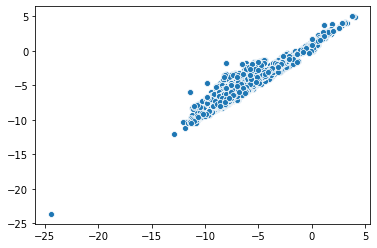

In [28]:
sb.scatterplot(np.log10(np.array(results_reference)), np.log10(np.array(results_2016)))

In [35]:
def masked_ratio(a, b):
    a, b = np.array(a), np.array(b)
    mask = (a != 0) * (b != 0)
    return a[mask] / b[mask]

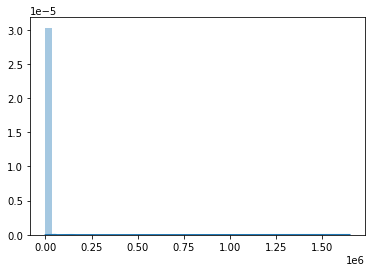

In [36]:
sb.distplot(masked_ratio(results_2016, results_reference))

In [31]:
def abnormal_ratio(a, b):
    if not a or not b:
        return
    ratio = abs(a / b)
    if 0.8 < ratio < 1.25:
        return
    return ratio

In [32]:
exceptions = sorted([
    (abnormal_ratio(results_2016[i], results_reference[i]), bw2data.get_activity(key)) 
    for i, key in enumerate(keys) 
    if abnormal_ratio(results_2016[i], results_reference[i])
], reverse=True)

In [33]:
len(exceptions)

16885

In [34]:
exceptions[:10]

[(1649230.4667126988, 'land use change, annual crop' (hectare, BR-MS, None)),
 (1649230.4667126988,
  'market for land use change, annual crop' (hectare, BR-MS, None)),
 (282226.93226109183,
  'vanilla seedling production, for planting' (unit, RoW, None)),
 (266990.05910256895,
  'vanilla seedling production, for planting' (unit, MG, None)),
 (145556.89891042918, 'vanilla production' (kilogram, RoW, None)),
 (141431.75619837918, 'vanilla production' (kilogram, MG, None)),
 (49209.69111163105,
  'market for land use change, annual crop' (hectare, BR-PR, None)),
 (49209.69111163104, 'land use change, annual crop' (hectare, BR-PR, None)),
 (46427.120813677335,
  'weaned calves production on native pasture, Pantanal' (kilogram, BR, None)),
 (46427.11866908204,
  'weaned calves production on native pasture, Pantanal' (kilogram, BR, None))]